In [3]:
import pickle
import pandas as pd
from google.cloud import bigquery
from google.cloud import storage
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from params import *
from utilities import *

import warnings
warnings.filterwarnings('ignore')

## Parametros

In [26]:
# Cliente de Bigquery
client_storage = storage.Client()

# Parametro para samplear o no los datos de entrenamiento
sample = False

# Parametro para crear clusters en los datos de entrenamiento
cluster = False

## Carga de datos entrenamiento

In [16]:
data_original = bring_data_from_bq(table = tables[0], client_bq = client_bq, save = True, read_local = False)
data = prepare_data(data_original)

data.head(5)

Leyendo datos de la tabla: diabetes
Informacion guardada en el archivo: diabetes.parquet


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
0,0.0,64.0,0.0,11001.0,0.0,0.0,57.6,1.5,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0
1,0.0,54.0,0.0,54001.0,1.0,0.0,57.6,1.5,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,0.0
2,0.0,69.0,0.0,15001.0,2.0,0.0,57.6,1.5,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,0.0
3,0.0,57.0,0.0,8001.0,3.0,0.0,57.6,1.5,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,1.0
4,0.0,50.0,0.0,19001.0,4.0,0.0,57.6,1.5,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,0.0


## Clusters

In [27]:
## Funciones para crear clusters

def peso_edad(value):
    if value < 45:
        return 0
    elif value < 54:
        return 1
    elif value <= 64:
        return 2
    else:
        return 3

def peso_imc(value):
    if value < 30:
        return 0
    elif value < 35:
        return 1
    elif value < 40:
        return 2
    else:
        return 3

def peso_pa(value, gender):

    if gender == 0:
        if value < 90:
            return 0
        elif value < 95:
            return 1
        else:
            return 2
    else:
        if value < 94:
            return 0
        elif value < 100:
            return 1
        else:
            return 2

def peso_ejercicio(value):
    if value == 2:
        return 2
    else:
        return 0

def peso_var_bivalente(value):
    if value == 1:
        return 2
    else:
        return 0

def peso_HDL(value):
    if value < 40:
        return 2
    elif value < 60:
        return 1
    else:
        return 0

def peso_LDL(value):
    if value < 130:
        return 0
    elif value < 160:
        return 1
    elif value < 190:
        return 2
    else:
        return 3

def peso_trigliceridos(value):
    if value < 150:
        return 0
    elif value < 200:
        return 1
    elif value < 500:
        return 2
    else:
        return 3

    
## Diccionario con las columnas y su respectiva funcion de cluster
dict_variables = {
    'edad' : peso_edad,
    'imc' : peso_imc,
    'PERIMETRO_ABDOMINAL' : peso_pa,
    'hace_ejercicio' : peso_ejercicio,
    'med_hipertension' : peso_var_bivalente,
    'familiar_dm' : peso_var_bivalente,
    'HDL' : peso_HDL,
    'LDL' : peso_LDL,
    'trigliceridos' : peso_trigliceridos,
    'ant_cardiovascular' : peso_var_bivalente,
    'dm_gestacional' : peso_var_bivalente,
}

In [28]:
df_cluster = pd.DataFrame()

if cluster:
    print('Se crearan clusters para las variables')
    print(list(dict_variables.keys()))
    for genero in [0,1]:
        print(f'Creando clusters para el genero: {genero}')
        data_temp = data[data.genero == genero].copy()
        for key in dict_variables:
            if key == 'PERIMETRO_ABDOMINAL':
                data_temp[key] = data_temp[key].map(lambda x: dict_variables[key](x, genero))
            else:
                data_temp[key] = data_temp[key].map(lambda x: dict_variables[key](x))
        df_cluster = pd.concat([df_cluster,data_temp])
        
df_cluster.head(5)

""


## Ajustes Modelo

In [16]:
# Conjunto de variables a usar en el entrenamiento

variables_to_train = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal', # Mirar
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente', # Mirar
                      'raza_paciente', # Mirar
                      'diabetes']

In [17]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train].copy()
df_to_train.head(5)

,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente,diabetes
3,57.0,0.0,8001.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,3.0,0.0,1.0
11,43.0,0.0,50001.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0,0.0,1.0
21,32.0,0.0,11001.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,3.0,0.0,1.0
26,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,4.0,0.0,1.0
31,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,4.0,0.0,1.0


In [20]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
3,57.0,0.0,8001.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,3.0,0.0
11,43.0,0.0,50001.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0,0.0
21,32.0,0.0,11001.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,3.0,0.0
26,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,4.0,0.0
31,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,4.0,0.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

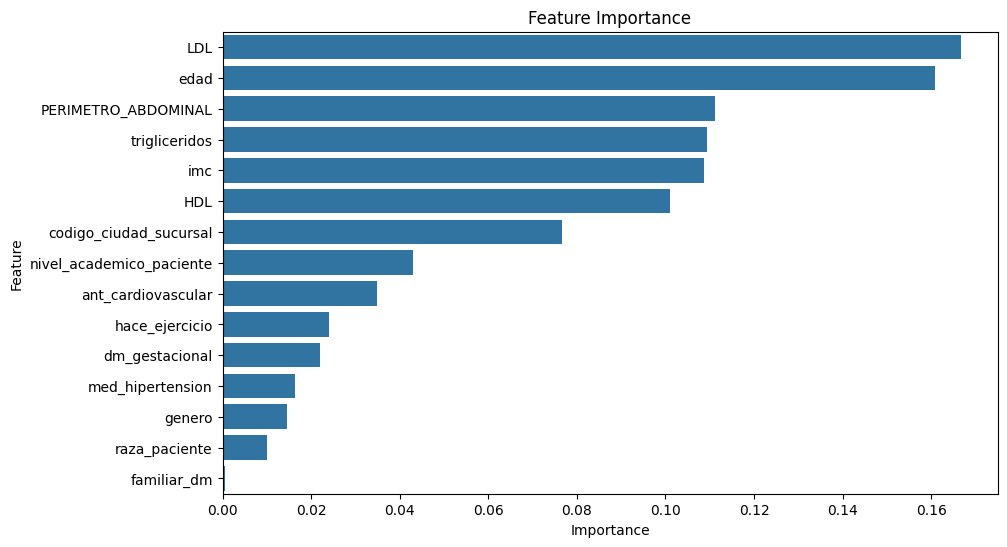

In [21]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [22]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 69.77
Modelo entrenado con f1 de: 70.8
La matriz de confusion es:


,Negativo,Positivo
Negativo,19274,9934
Positivo,7666,21342


In [23]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 64.06%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
269346,0.0,78.0,0.0,52001.0,1.0,1.0,69.0,1.58,27.639801,46.0,81.0,95.0,1.0,0.0,1.0,0.0,92.0,1.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 89.46%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
218535,0.0,53.0,0.0,25754.0,3.0,0.0,79.1,1.58,31.685627,40.0,54.0,254.0,0.0,0.0,1.0,0.0,107.0,1.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 51.09%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
116187,0.0,61.0,1.0,52001.0,0.0,1.0,81.0,1.72,27.379665,43.0,182.0,154.0,1.0,0.0,1.0,0.0,87.0,0.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 26.92%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
36360,0.0,58.0,0.0,19001.0,0.0,1.0,67.0,1.59,26.502116,52.5,143.0,143.5,0.0,0.0,0.0,0.0,86.0,2.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 44.41%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
105470,0.0,67.0,0.0,52001.0,0.0,1.0,63.0,1.55,26.222685,45.0,131.8,211.0,1.0,0.0,1.0,0.0,88.0,3.0,0.0


## Evaluación sin las variables 
codigo_ciudad_sucursal, nivel_academico_paciente, raza_paciente

In [24]:
# Conjunto de variables a usar en el entrenamiento 
# Sin codigo_ciudad_sucursal
# Sin nivel_academico_paciente
# Sin raza_paciente

variables_to_train_sin = ['edad',
                      'genero',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'diabetes']

In [25]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin].copy()
df_to_train.head(5)

,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
3,57.0,0.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,1.0
11,43.0,0.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,1.0
21,32.0,0.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,1.0
26,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,1.0
31,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,1.0


In [27]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin[:-1]]
y = df_to_train[variables_to_train_sin[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio
3,57.0,0.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0
11,43.0,0.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0
21,32.0,0.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0
26,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0
31,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

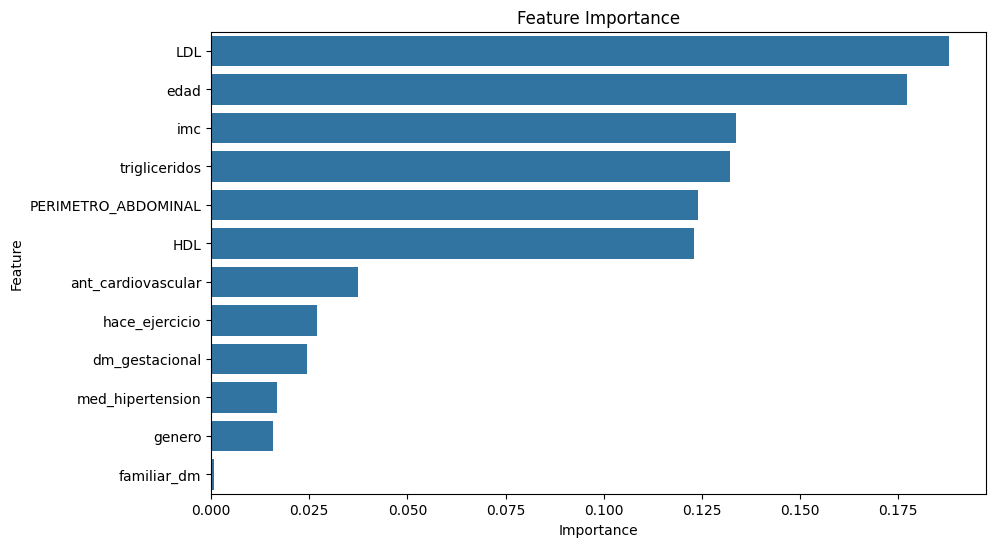

In [28]:
# Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [29]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 69.14
Modelo entrenado con f1 de: 70.21
La matriz de confusion es:


,Negativo,Positivo
Negativo,19084,10088
Positivo,7878,21167


In [30]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 39.53%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
134187,0.0,54.0,1.0,19001.0,0.0,0.0,77.0,1.64,28.628792,33.5,97.5,100.0,1.0,0.0,1.0,0.0,95.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 46.68%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
189662,0.0,92.0,0.0,8001.0,3.0,0.0,74.5,1.6,29.101562,52.2,141.0,113.0,1.0,0.0,1.0,0.0,81.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 60.77%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
60481,0.0,52.0,1.0,50001.0,4.0,0.0,102.8,1.72,34.748513,55.2,94.1,93.4,0.0,0.0,0.0,0.0,113.0,0.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 49.75%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
106145,0.0,69.0,0.0,63001.0,0.0,0.0,86.0,1.65,31.588613,52.0,121.0,72.0,1.0,0.0,1.0,0.0,100.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 51.05%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
42807,0.0,69.0,0.0,52001.0,1.0,1.0,85.0,1.65,31.221304,48.0,116.0,90.0,0.0,0.0,0.0,0.0,96.0,2.0,1.0


## Evaluación sin las variables 
codigo_ciudad_sucursal, nivel_academico_paciente


In [41]:
# Conjunto de variables a usar en el entrenamiento
# Sin codigo_ciudad_sucursal
# Sin nivel_academico_paciente

variables_to_train_sin_1 = ['edad',
                      'genero',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'raza_paciente', # Mirar
                      'diabetes']

In [42]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_1].copy()
df_to_train.head(5)

,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,raza_paciente,diabetes
3,57.0,0.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,0.0,1.0
11,43.0,0.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0,1.0
21,32.0,0.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,0.0,1.0
26,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,0.0,1.0
31,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,0.0,1.0


In [43]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_1[:-1]]
y = df_to_train[variables_to_train_sin_1[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,raza_paciente
3,57.0,0.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,0.0
11,43.0,0.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0
21,32.0,0.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,0.0
26,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,0.0
31,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,0.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

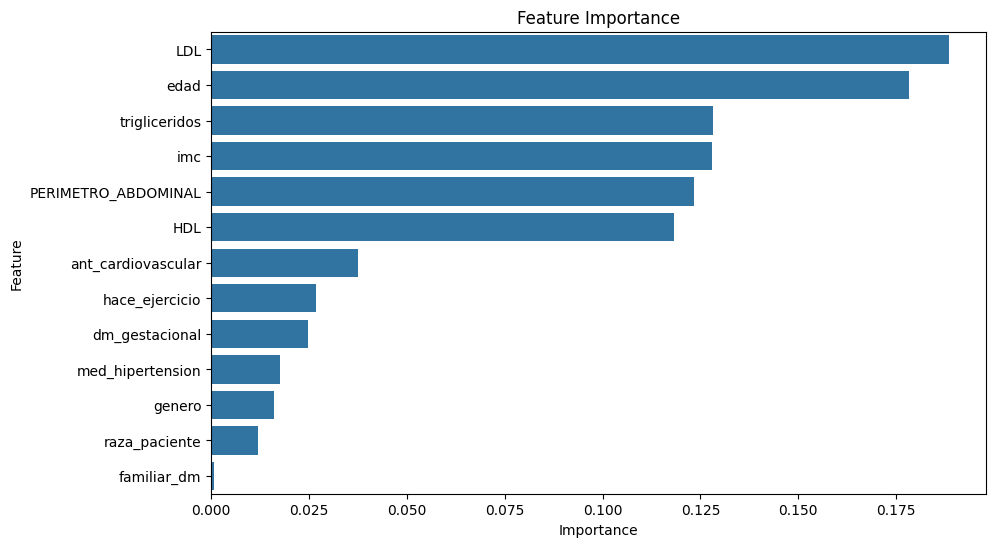

In [44]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [45]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 68.93
Modelo entrenado con f1 de: 69.79
La matriz de confusion es:


,Negativo,Positivo
Negativo,19237,9971
Positivo,8116,20892


In [46]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 34.7%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
44678,0.0,62.0,0.0,11001.0,0.0,0.0,62.0,1.49,27.92667,35.0,143.0,185.0,0.0,0.0,0.0,0.0,94.0,2.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 18.34%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
51416,0.0,50.0,0.0,19001.0,5.0,0.0,57.0,1.6,22.265625,50.2,139.0,124.0,0.0,0.0,0.0,0.0,73.0,1.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 60.81%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
203121,0.0,74.0,1.0,19698.0,1.0,1.0,61.0,1.72,20.619254,36.0,119.0,171.0,1.0,0.0,1.0,0.0,80.0,2.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 42.08%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
221636,0.0,78.0,0.0,54001.0,0.0,0.0,58.2,1.5,25.866667,52.1,80.12,73.9,1.0,0.0,1.0,0.0,81.0,2.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 43.66%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
233376,0.0,66.0,0.0,68679.0,7.0,0.0,73.0,1.59,28.87544,53.0,167.2,191.0,1.0,0.0,1.0,0.0,83.0,2.0,0.0


## Evaluación sin las variables 
codigo_ciudad_sucursal y raza_paciente

In [47]:
# Conjunto de variables a usar en el entrenamiento
# Sin codigo_ciudad_sucursal
# Sin raza_paciente

variables_to_train_sin_2 = ['edad',
                      'genero',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente', # Mirar
                      'diabetes']

In [48]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_2].copy()
df_to_train.head(5)

,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,diabetes
3,57.0,0.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,3.0,1.0
11,43.0,0.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0,1.0
21,32.0,0.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,3.0,1.0
26,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,4.0,1.0
31,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,4.0,1.0


In [49]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_2[:-1]]
y = df_to_train[variables_to_train_sin_2[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente
3,57.0,0.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,3.0
11,43.0,0.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0
21,32.0,0.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,3.0
26,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,4.0
31,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,4.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

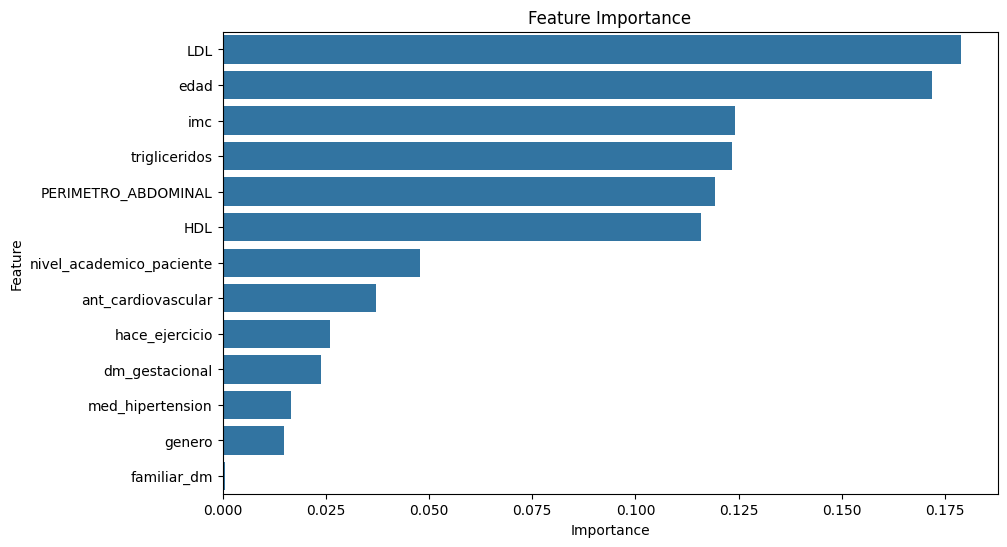

In [50]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [51]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 69.14
Modelo entrenado con f1 de: 70.17
La matriz de confusion es:


,Negativo,Positivo
Negativo,19120,10089
Positivo,7877,21131


In [53]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 24.5%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
52295,0.0,58.0,0.0,68001.0,1.0,0.0,70.8,1.5,31.466667,52.8,116.0,128.0,0.0,0.0,0.0,0.0,70.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 17.44%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
186103,0.0,46.0,0.0,52001.0,0.0,1.0,62.1,1.58,24.875821,46.0,151.0,137.0,1.0,0.0,1.0,0.0,83.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 68.25%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
101048,0.0,83.0,0.0,15001.0,0.0,0.0,61.0,1.55,25.390219,49.0,46.0,75.0,1.0,0.0,1.0,0.0,89.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 63.09%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
131974,0.0,69.0,1.0,19001.0,9.0,0.0,82.4,1.63,31.013587,40.0,99.4,133.0,1.0,0.0,1.0,0.0,105.0,1.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 77.41%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
173661,0.0,65.0,1.0,41001.0,0.0,0.0,113.5,1.7,39.273356,48.0,55.0,96.0,1.0,0.0,1.0,0.0,124.0,1.0,0.0


## Evaluación sin las variables 
codigo_ciudad_sucursal 

In [54]:
# Conjunto de variables a usar en el entrenamiento
# Sin codigo_ciudad_sucursal

variables_to_train_sin_4 = ['edad',
                      'genero',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente', # Mirar
                      'raza_paciente', # Mirar
                      'diabetes']

In [55]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_4].copy()
df_to_train.head(5)

,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente,diabetes
3,57.0,0.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,3.0,0.0,1.0
11,43.0,0.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0,0.0,1.0
21,32.0,0.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,3.0,0.0,1.0
26,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,4.0,0.0,1.0
31,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,4.0,0.0,1.0


In [56]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_4[:-1]]
y = df_to_train[variables_to_train_sin_4[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
3,57.0,0.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,3.0,0.0
11,43.0,0.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0,0.0
21,32.0,0.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,3.0,0.0
26,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,4.0,0.0
31,40.0,0.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,4.0,0.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

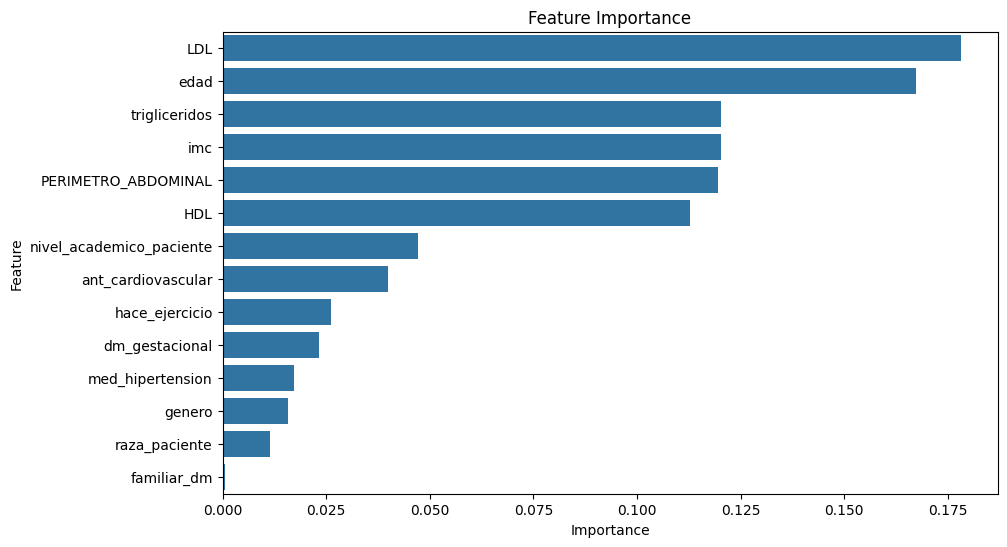

In [57]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [58]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 69.32
Modelo entrenado con f1 de: 70.33
La matriz de confusion es:


,Negativo,Positivo
Negativo,19191,9967
Positivo,7893,21165


In [59]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 62.05%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
137882,0.0,76.0,0.0,13001.0,0.0,0.0,67.0,1.65,24.609734,35.0,169.0,258.0,1.0,0.0,1.0,0.0,86.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 59.08%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
184630,0.0,66.0,0.0,68001.0,0.0,0.0,67.3,1.49,30.31395,46.4,72.2,72.0,1.0,1.0,1.0,0.0,100.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 50.21%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
272392,0.0,53.0,0.0,54001.0,0.0,0.0,80.7,1.48,36.842586,35.0,155.0,156.0,1.0,0.0,1.0,0.0,100.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 55.0%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
100651,0.0,67.0,1.0,11001.0,12.0,0.0,68.0,1.68,24.092971,41.0,81.0,66.0,1.0,0.0,1.0,0.0,93.0,0.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 19.07%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
10020,0.0,66.0,0.0,70001.0,5.0,0.0,63.0,1.55,26.222685,52.75,139.6,125.7,0.0,0.0,0.0,0.0,92.0,3.0,0.0


## Evaluación sin las variables 
nivel_academico_paciente

In [60]:
# Conjunto de variables a usar en el entrenamiento
# Sin nivel_academico_paciente

variables_to_train_sin_3 = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal', # Mirar
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'raza_paciente', # Mirar
                      'diabetes']

In [61]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_3].copy()
df_to_train.head(5)

,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,raza_paciente,diabetes
3,57.0,0.0,8001.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,0.0,1.0
11,43.0,0.0,50001.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0,1.0
21,32.0,0.0,11001.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,0.0,1.0
26,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,0.0,1.0
31,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,0.0,1.0


In [62]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_3[:-1]]
y = df_to_train[variables_to_train_sin_3[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,raza_paciente
3,57.0,0.0,8001.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,0.0
11,43.0,0.0,50001.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0
21,32.0,0.0,11001.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,0.0
26,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,0.0
31,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,0.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

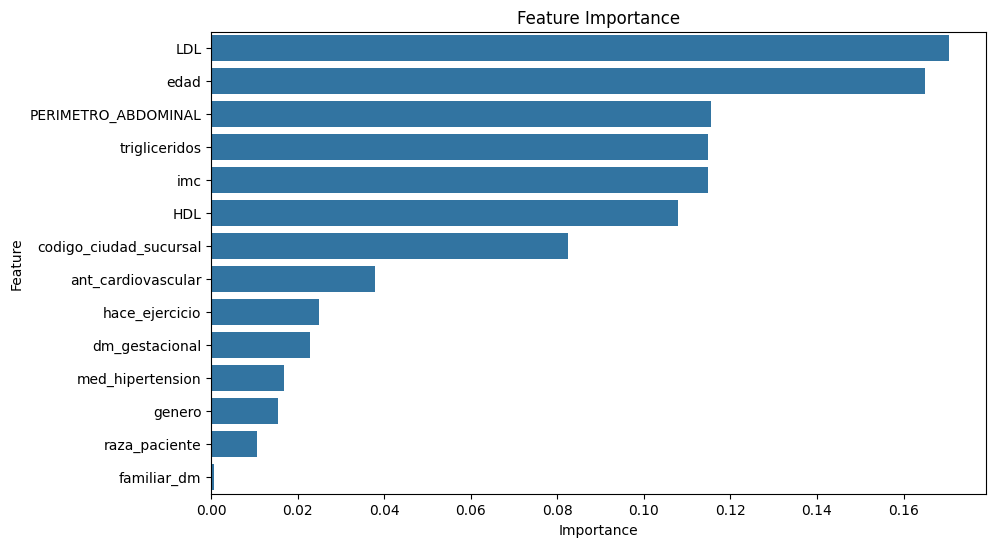

In [63]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [64]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 69.71
Modelo entrenado con f1 de: 70.67
La matriz de confusion es:


,Negativo,Positivo
Negativo,19342,9816
Positivo,7817,21241


In [65]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 22.7%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
115282,0.0,51.0,0.0,5001.0,0.0,0.0,68.0,1.59,26.89767,54.0,176.0,171.0,1.0,0.0,1.0,0.0,85.0,1.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 18.77%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
33624,0.0,51.0,0.0,19001.0,0.0,0.0,67.9,1.57,27.546756,46.3,197.0,266.0,1.0,0.0,0.0,0.0,90.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 40.62%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
201931,0.0,46.0,1.0,54001.0,1.0,0.0,83.0,1.69,29.060607,34.1,86.9,135.0,1.0,0.0,1.0,0.0,105.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 33.7%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
245916,0.0,53.0,0.0,11001.0,0.0,0.0,65.5,1.5,29.111111,30.6,122.0,115.8,1.0,0.0,1.0,0.0,84.0,1.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 42.26%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
175419,0.0,67.0,0.0,19698.0,0.0,0.0,58.0,1.53,24.776795,62.0,164.0,77.0,1.0,0.0,1.0,0.0,86.0,2.0,1.0


## Evaluación sin las variables 
raza_paciente

In [66]:
# Conjunto de variables a usar en el entrenamiento

variables_to_train_sin_5 = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal', # Mirar
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente', # Mirar
                      'diabetes']

In [67]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_5].copy()
df_to_train.head(5)

,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,diabetes
3,57.0,0.0,8001.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,3.0,1.0
11,43.0,0.0,50001.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0,1.0
21,32.0,0.0,11001.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,3.0,1.0
26,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,4.0,1.0
31,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,4.0,1.0


In [68]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_5[:-1]]
y = df_to_train[variables_to_train_sin_5[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente
3,57.0,0.0,8001.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,3.0
11,43.0,0.0,50001.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0
21,32.0,0.0,11001.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,3.0
26,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,4.0
31,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,4.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

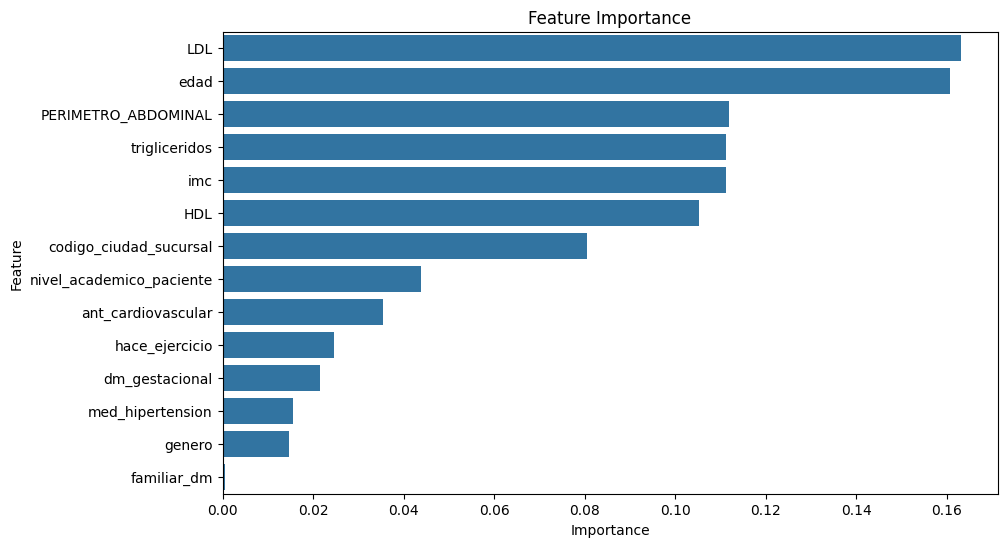

In [69]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [70]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 70.07
Modelo entrenado con f1 de: 71.05
La matriz de confusion es:


,Negativo,Positivo
Negativo,19408,9750
Positivo,7673,21385


In [71]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 71.87%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
282952,0.0,64.0,1.0,11001.0,1.0,0.0,80.0,1.66,29.03179,38.6,57.06,111.18,1.0,0.0,1.0,0.0,100.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 49.48%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
92759,0.0,58.0,0.0,11001.0,8.0,5.0,66.7,1.46,31.291049,47.0,209.0,179.0,1.0,0.0,1.0,0.0,100.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 20.02%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
481,0.0,41.0,0.0,20011.0,3.0,0.0,55.6,0.5,222.4,46.0,126.0,101.0,0.0,0.0,0.0,0.0,66.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 77.18%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
212649,0.0,77.0,1.0,8001.0,0.0,0.0,84.0,1.57,34.078462,72.0,50.5,84.0,1.0,0.0,1.0,0.0,108.0,0.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 68.02%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
172180,0.0,76.0,1.0,8001.0,0.0,0.0,72.9,1.65,26.77686,40.0,87.0,252.0,1.0,0.0,1.0,0.0,98.0,3.0,1.0


## Evaluación sin las variables 
nivel_academico_paciente y raza_paciente

In [72]:
# Conjunto de variables a usar en el entrenamiento
# Sin nivel_academico_paciente
# Sin raza_paciente

variables_to_train_sin_6 = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal', # Mirar
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'diabetes']

In [73]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_6].copy()
df_to_train.head(5)

,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
3,57.0,0.0,8001.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,1.0
11,43.0,0.0,50001.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,1.0
21,32.0,0.0,11001.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,1.0
26,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,1.0
31,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,1.0


In [74]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_6[:-1]]
y = df_to_train[variables_to_train_sin_6[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio
3,57.0,0.0,8001.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0
11,43.0,0.0,50001.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0
21,32.0,0.0,11001.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0
26,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0
31,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

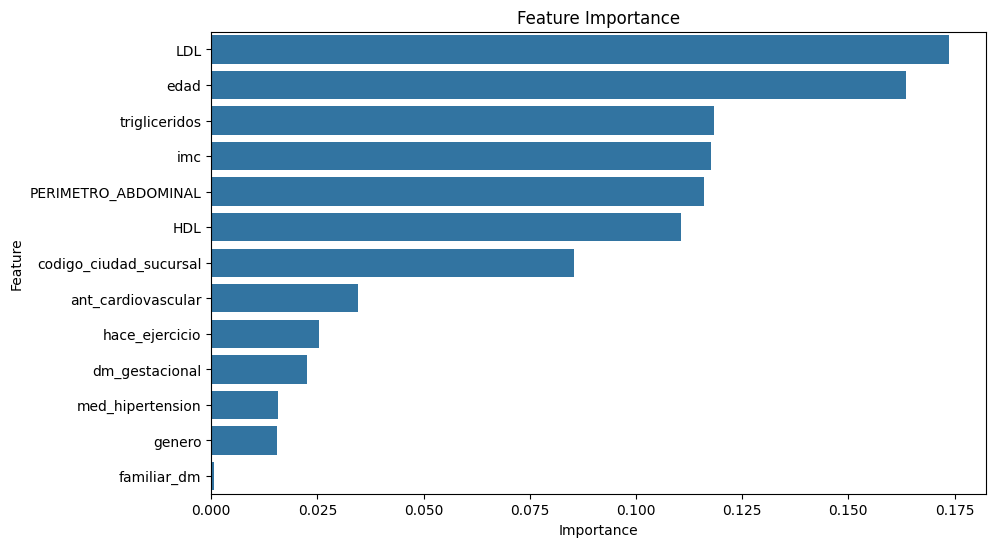

In [75]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [76]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 69.94
Modelo entrenado con f1 de: 70.98
La matriz de confusion es:


,Negativo,Positivo
Negativo,19315,9893
Positivo,7605,21403


In [77]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 14.4%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
225357,0.0,41.0,1.0,47001.0,0.0,0.0,82.0,1.76,26.472107,37.4,98.0,119.72,1.0,0.0,1.0,0.0,90.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 29.83%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
152073,0.0,58.0,0.0,52001.0,0.0,1.0,79.3,1.62,30.21643,50.0,125.0,163.0,1.0,0.0,1.0,0.0,85.0,2.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 28.7%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
74491,0.0,49.0,1.0,8001.0,7.0,0.0,67.0,1.68,23.738662,39.5,120.0,156.0,0.0,0.0,0.0,0.0,85.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 13.16%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
6279,0.0,26.0,0.0,47001.0,0.0,0.0,104.8,1.77,33.451435,32.2,125.0,168.9,0.0,0.0,0.0,0.0,109.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 54.42%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
18408,0.0,71.0,1.0,41001.0,3.0,0.0,68.6,1.71,23.46021,48.6,144.2,129.0,1.0,0.0,0.0,0.0,97.0,2.0,0.0


Cluster = True 
Sample = False

## Todas las variables

In [82]:
# Conjunto de variables a usar en el entrenamiento

variables_to_train_7 = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal', # Mirar
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente', # Mirar
                      'raza_paciente', # Mirar
                      'diabetes']

In [83]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_7].copy()
df_to_train.head(5)

,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente,diabetes
0,2,0.0,11001.0,0,1,0,0,0,0,0,0,0,2,0.0,0.0,0.0
1,2,0.0,54001.0,0,1,0,2,0,0,0,0,0,2,1.0,0.0,0.0
2,3,0.0,15001.0,0,0,2,0,0,0,0,0,0,0,2.0,0.0,0.0
3,2,0.0,8001.0,0,2,1,2,0,0,0,0,2,2,3.0,0.0,1.0
4,1,0.0,19001.0,0,1,1,1,0,0,0,0,0,2,4.0,0.0,0.0


In [84]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_7[:-1]]
y = df_to_train[variables_to_train_7[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
0,2,0.0,11001.0,0,1,0,0,0,0,0,0,0,2,0.0,0.0
1,2,0.0,54001.0,0,1,0,2,0,0,0,0,0,2,1.0,0.0
2,3,0.0,15001.0,0,0,2,0,0,0,0,0,0,0,2.0,0.0
3,2,0.0,8001.0,0,2,1,2,0,0,0,0,2,2,3.0,0.0
4,1,0.0,19001.0,0,1,1,1,0,0,0,0,0,2,4.0,0.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

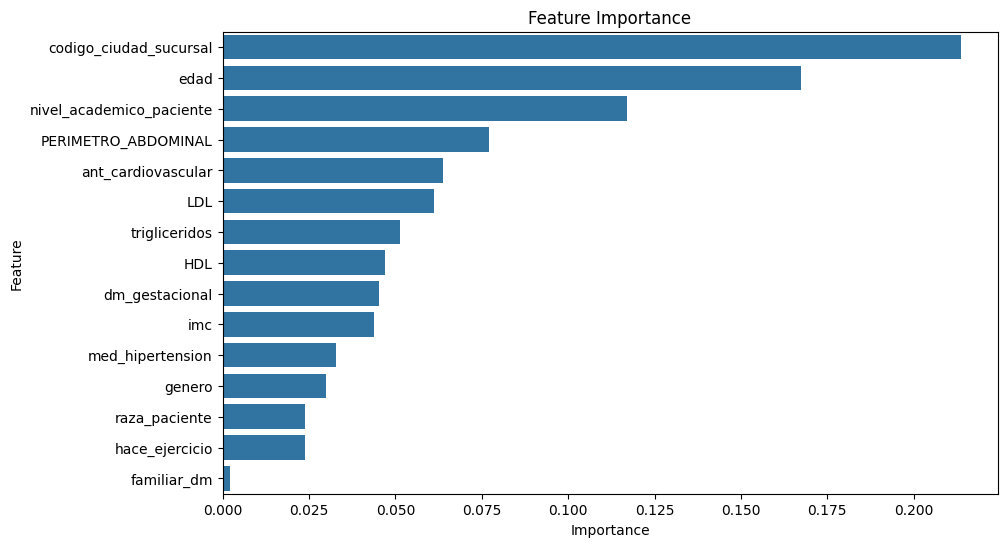

In [85]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [86]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 71.97
Modelo entrenado con f1 de: 31.92
La matriz de confusion es:


,Negativo,Positivo
Negativo,63128,4305
Positivo,22759,6345


In [87]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 15.85%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
49639,0.0,44.0,1.0,70001.0,4.0,0.0,73.8,1.86,21.331946,53.6,53.2,86.0,0.0,0.0,0.0,0.0,94.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 6.51%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
97735,0.0,31.0,0.0,8001.0,5.0,0.0,76.0,1.67,27.250887,46.4,85.8,112.0,1.0,0.0,1.0,0.0,88.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 42.81%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
237286,0.0,76.0,0.0,85001.0,1.0,0.0,68.0,1.62,25.910684,44.0,80.0,73.0,1.0,0.0,1.0,0.0,85.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 11.76%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
10457,0.0,53.0,1.0,19001.0,0.0,1.0,72.0,1.65,26.446281,29.7,162.1,241.0,0.0,0.0,0.0,0.0,100.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 29.35%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
123882,0.0,67.0,1.0,8001.0,7.0,1.0,69.7,1.65,25.601469,28.0,59.0,185.0,1.0,0.0,1.0,0.0,95.0,3.0,0.0


## Evaluación sin las variables 
codigo_ciudad_sucursal, nivel_academico_paciente, raza_paciente

In [88]:
# Conjunto de variables a usar en el entrenamiento 
# Sin codigo_ciudad_sucursal
# Sin nivel_academico_paciente
# Sin raza_paciente

variables_to_train_sin_8 = ['edad',
                      'genero',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'diabetes']

In [89]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_8].copy()
df_to_train.head(5)

,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
0,2,0.0,0,1,0,0,0,0,0,0,0,2,0.0
1,2,0.0,0,1,0,2,0,0,0,0,0,2,0.0
2,3,0.0,0,0,2,0,0,0,0,0,0,0,0.0
3,2,0.0,0,2,1,2,0,0,0,0,2,2,1.0
4,1,0.0,0,1,1,1,0,0,0,0,0,2,0.0


In [90]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_8[:-1]]
y = df_to_train[variables_to_train_sin_8[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio
0,2,0.0,0,1,0,0,0,0,0,0,0,2
1,2,0.0,0,1,0,2,0,0,0,0,0,2
2,3,0.0,0,0,2,0,0,0,0,0,0,0
3,2,0.0,0,2,1,2,0,0,0,0,2,2
4,1,0.0,0,1,1,1,0,0,0,0,0,2


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

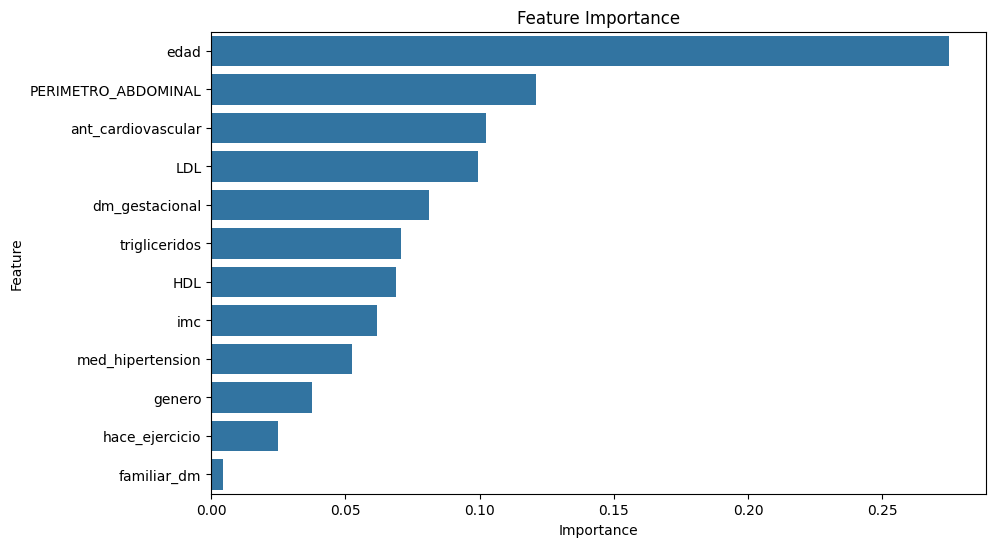

In [91]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [92]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 71.0
Modelo entrenado con f1 de: 28.19
La matriz de confusion es:


,Negativo,Positivo
Negativo,63042,4391
Positivo,23608,5496


In [93]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 31.61%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
11483,0.0,65.0,0.0,15001.0,4.0,0.0,67.9,1.56,27.901052,52.0,100.0,82.0,0.0,0.0,0.0,0.0,94.0,2.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 19.6%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
61369,0.0,37.0,0.0,13001.0,7.0,0.0,77.0,1.6,30.078125,37.7,157.0,82.0,0.0,0.0,0.0,0.0,90.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 11.67%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
35325,0.0,37.0,0.0,15001.0,4.0,0.0,67.0,1.5,29.777778,38.0,86.0,51.0,0.0,0.0,0.0,0.0,103.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 37.86%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
203525,0.0,63.0,1.0,11001.0,0.0,3.0,78.3,1.66,28.414864,34.3,39.8,101.5,1.0,0.0,1.0,0.0,95.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 37.95%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
273968,0.0,60.0,0.0,19001.0,1.0,0.0,92.0,1.64,34.20583,56.6,61.7,199.7,1.0,0.0,1.0,0.0,108.0,3.0,0.0


## Evaluación sin las variables 
codigo_ciudad_sucursal, nivel_academico_paciente

In [94]:
# Conjunto de variables a usar en el entrenamiento
# Sin codigo_ciudad_sucursal
# Sin nivel_academico_paciente

variables_to_train_sin_9 = ['edad',
                      'genero',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'raza_paciente', # Mirar
                      'diabetes']

In [95]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_9].copy()
df_to_train.head(5)

,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,raza_paciente,diabetes
0,2,0.0,0,1,0,0,0,0,0,0,0,2,0.0,0.0
1,2,0.0,0,1,0,2,0,0,0,0,0,2,0.0,0.0
2,3,0.0,0,0,2,0,0,0,0,0,0,0,0.0,0.0
3,2,0.0,0,2,1,2,0,0,0,0,2,2,0.0,1.0
4,1,0.0,0,1,1,1,0,0,0,0,0,2,0.0,0.0


In [96]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_9[:-1]]
y = df_to_train[variables_to_train_sin_9[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,raza_paciente
0,2,0.0,0,1,0,0,0,0,0,0,0,2,0.0
1,2,0.0,0,1,0,2,0,0,0,0,0,2,0.0
2,3,0.0,0,0,2,0,0,0,0,0,0,0,0.0
3,2,0.0,0,2,1,2,0,0,0,0,2,2,0.0
4,1,0.0,0,1,1,1,0,0,0,0,0,2,0.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

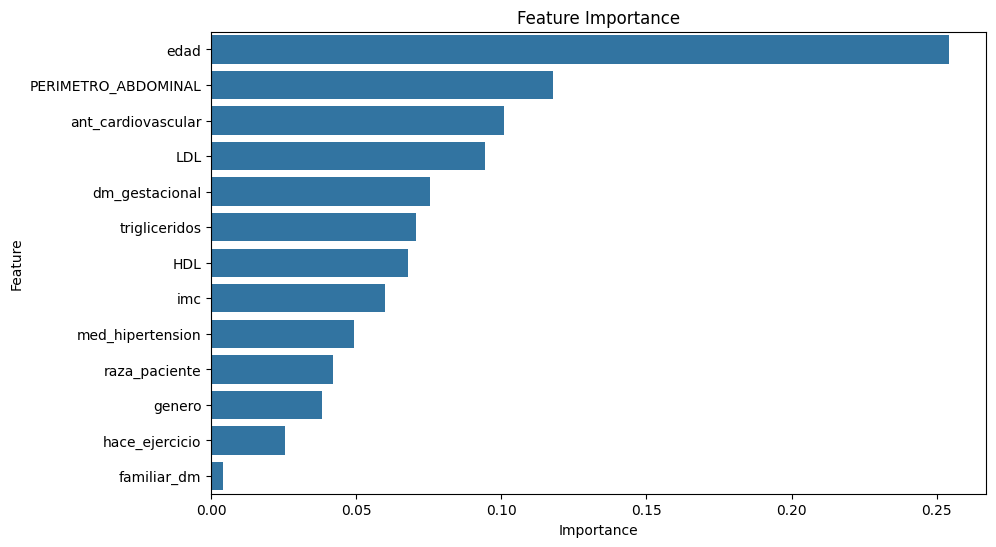

In [97]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [98]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 71.1
Modelo entrenado con f1 de: 29.13
La matriz de confusion es:


,Negativo,Positivo
Negativo,62906,4527
Positivo,23371,5733


In [99]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 20.95%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
124811,0.0,58.0,1.0,23466.0,4.0,0.0,68.9,1.74,22.7573,49.4,183.1,137.9,1.0,0.0,1.0,0.0,79.0,2.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 50.86%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
227497,0.0,73.0,0.0,54001.0,3.0,0.0,94.0,1.52,40.685596,42.4,77.8,109.0,0.0,0.0,1.0,0.0,127.0,2.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 33.94%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
102848,0.0,86.0,0.0,19001.0,1.0,0.0,55.0,1.5,24.444444,51.0,78.0,63.6,1.0,0.0,1.0,0.0,89.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 17.87%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
245591,0.0,50.0,0.0,25754.0,3.0,0.0,79.0,1.5,35.111111,66.0,136.0,106.0,1.0,0.0,1.0,0.0,100.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 33.86%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
104996,0.0,52.0,1.0,13001.0,3.0,0.0,96.4,1.68,34.155329,42.0,103.6,101.5,1.0,0.0,1.0,0.0,114.0,0.0,0.0


## Evaluación sin las variables 
codigo_ciudad_sucursal y raza_paciente

In [100]:
# Conjunto de variables a usar en el entrenamiento
# Sin codigo_ciudad_sucursal
# Sin raza_paciente

variables_to_train_sin_10 = ['edad',
                      'genero',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente', # Mirar
                      'diabetes']

In [101]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_10].copy()
df_to_train.head(5)

,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,diabetes
0,2,0.0,0,1,0,0,0,0,0,0,0,2,0.0,0.0
1,2,0.0,0,1,0,2,0,0,0,0,0,2,1.0,0.0
2,3,0.0,0,0,2,0,0,0,0,0,0,0,2.0,0.0
3,2,0.0,0,2,1,2,0,0,0,0,2,2,3.0,1.0
4,1,0.0,0,1,1,1,0,0,0,0,0,2,4.0,0.0


In [102]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_10[:-1]]
y = df_to_train[variables_to_train_sin_10[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente
0,2,0.0,0,1,0,0,0,0,0,0,0,2,0.0
1,2,0.0,0,1,0,2,0,0,0,0,0,2,1.0
2,3,0.0,0,0,2,0,0,0,0,0,0,0,2.0
3,2,0.0,0,2,1,2,0,0,0,0,2,2,3.0
4,1,0.0,0,1,1,1,0,0,0,0,0,2,4.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

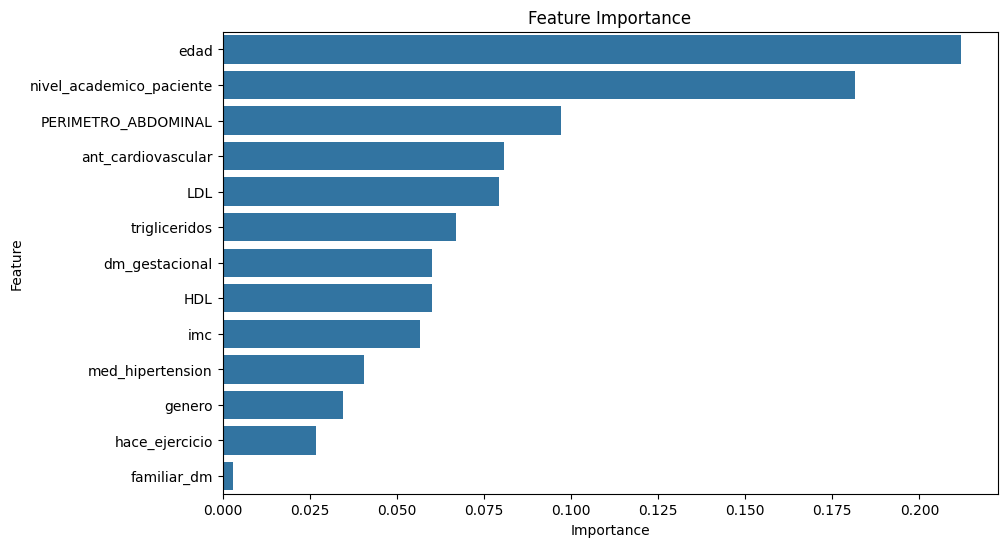

In [103]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [104]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 71.03
Modelo entrenado con f1 de: 30.61
La matriz de confusion es:


,Negativo,Positivo
Negativo,62405,5028
Positivo,22936,6168


In [105]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 39.88%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
219708,0.0,73.0,0.0,15001.0,0.0,0.0,62.3,1.61,24.034567,59.0,111.0,199.0,1.0,0.0,1.0,0.0,89.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 37.29%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
179933,0.0,56.0,0.0,5615.0,0.0,0.0,78.2,1.6,30.546875,45.3,137.3,242.7,1.0,0.0,1.0,0.0,96.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 45.95%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
10207,0.0,67.0,1.0,19001.0,1.0,0.0,86.0,1.65,31.588613,54.5,109.7,79.0,0.0,0.0,0.0,0.0,104.0,0.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 31.67%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
271795,0.0,58.0,0.0,19001.0,0.0,0.0,58.0,1.52,25.103878,55.6,155.0,133.6,1.0,0.0,1.0,0.0,93.0,2.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 37.7%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
127734,0.0,89.0,1.0,5001.0,0.0,0.0,68.7,1.7,23.771626,40.0,75.0,187.0,1.0,0.0,1.0,0.0,93.0,2.0,1.0


## Evaluación sin las variables 
codigo_ciudad_sucursal 

In [106]:
# Conjunto de variables a usar en el entrenamiento
# Sin codigo_ciudad_sucursal

variables_to_train_sin_11 = ['edad',
                      'genero',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente', # Mirar
                      'raza_paciente', # Mirar
                      'diabetes']

In [107]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_11].copy()
df_to_train.head(5)

,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente,diabetes
0,2,0.0,0,1,0,0,0,0,0,0,0,2,0.0,0.0,0.0
1,2,0.0,0,1,0,2,0,0,0,0,0,2,1.0,0.0,0.0
2,3,0.0,0,0,2,0,0,0,0,0,0,0,2.0,0.0,0.0
3,2,0.0,0,2,1,2,0,0,0,0,2,2,3.0,0.0,1.0
4,1,0.0,0,1,1,1,0,0,0,0,0,2,4.0,0.0,0.0


In [108]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_11[:-1]]
y = df_to_train[variables_to_train_sin_11[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
0,2,0.0,0,1,0,0,0,0,0,0,0,2,0.0,0.0
1,2,0.0,0,1,0,2,0,0,0,0,0,2,1.0,0.0
2,3,0.0,0,0,2,0,0,0,0,0,0,0,2.0,0.0
3,2,0.0,0,2,1,2,0,0,0,0,2,2,3.0,0.0
4,1,0.0,0,1,1,1,0,0,0,0,0,2,4.0,0.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

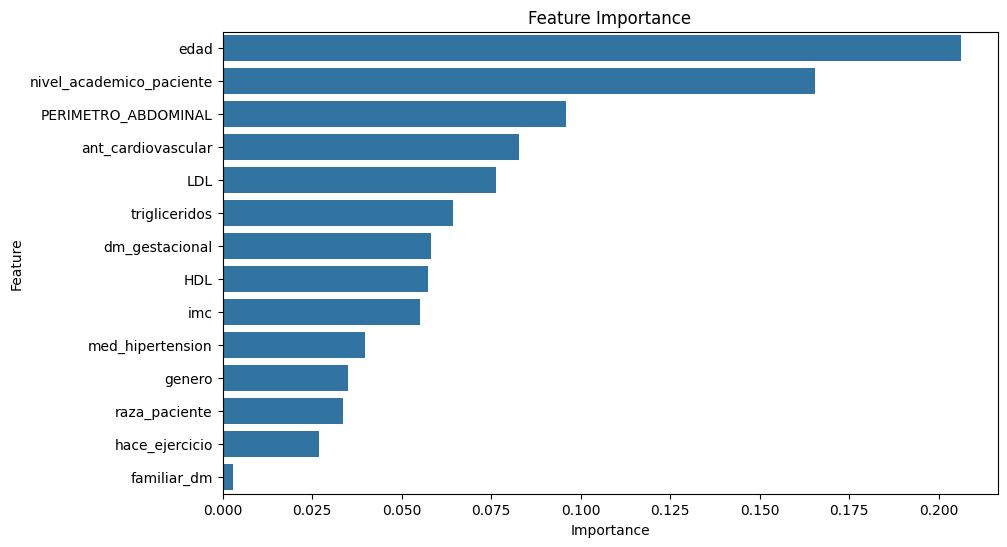

In [110]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [111]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 71.19
Modelo entrenado con f1 de: 30.75
La matriz de confusion es:


,Negativo,Positivo
Negativo,62555,4878
Positivo,22930,6174


In [112]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 51.56%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
272966,0.0,67.0,0.0,73001.0,0.0,0.0,65.0,1.46,30.493526,46.0,92.6,240.3,1.0,0.0,1.0,0.0,90.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 3.28%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
53710,0.0,37.0,0.0,19001.0,0.0,0.0,83.5,1.57,33.875614,37.0,85.0,161.0,0.0,0.0,0.0,0.0,91.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 10.34%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
76996,0.0,22.0,1.0,8001.0,0.0,0.0,68.0,1.69,23.80869,54.9,73.7,70.0,0.0,0.0,0.0,0.0,76.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 8.76%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
104916,0.0,40.0,0.0,63001.0,0.0,1.0,69.0,1.61,26.619343,36.7,85.0,115.5,1.0,0.0,1.0,0.0,85.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 53.06%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
271271,0.0,77.0,1.0,50001.0,2.0,0.0,80.0,1.7,27.681661,53.0,82.0,59.0,1.0,0.0,1.0,0.0,101.0,3.0,0.0


## Evaluación sin las variables 
nivel_academico_paciente

In [113]:
# Conjunto de variables a usar en el entrenamiento
# Sin nivel_academico_paciente

variables_to_train_sin_12 = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal', # Mirar
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'raza_paciente', # Mirar
                      'diabetes']

In [114]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_12].copy()
df_to_train.head(5)

,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,raza_paciente,diabetes
0,2,0.0,11001.0,0,1,0,0,0,0,0,0,0,2,0.0,0.0
1,2,0.0,54001.0,0,1,0,2,0,0,0,0,0,2,0.0,0.0
2,3,0.0,15001.0,0,0,2,0,0,0,0,0,0,0,0.0,0.0
3,2,0.0,8001.0,0,2,1,2,0,0,0,0,2,2,0.0,1.0
4,1,0.0,19001.0,0,1,1,1,0,0,0,0,0,2,0.0,0.0


In [115]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_12[:-1]]
y = df_to_train[variables_to_train_sin_12[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,raza_paciente
0,2,0.0,11001.0,0,1,0,0,0,0,0,0,0,2,0.0
1,2,0.0,54001.0,0,1,0,2,0,0,0,0,0,2,0.0
2,3,0.0,15001.0,0,0,2,0,0,0,0,0,0,0,0.0
3,2,0.0,8001.0,0,2,1,2,0,0,0,0,2,2,0.0
4,1,0.0,19001.0,0,1,1,1,0,0,0,0,0,2,0.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

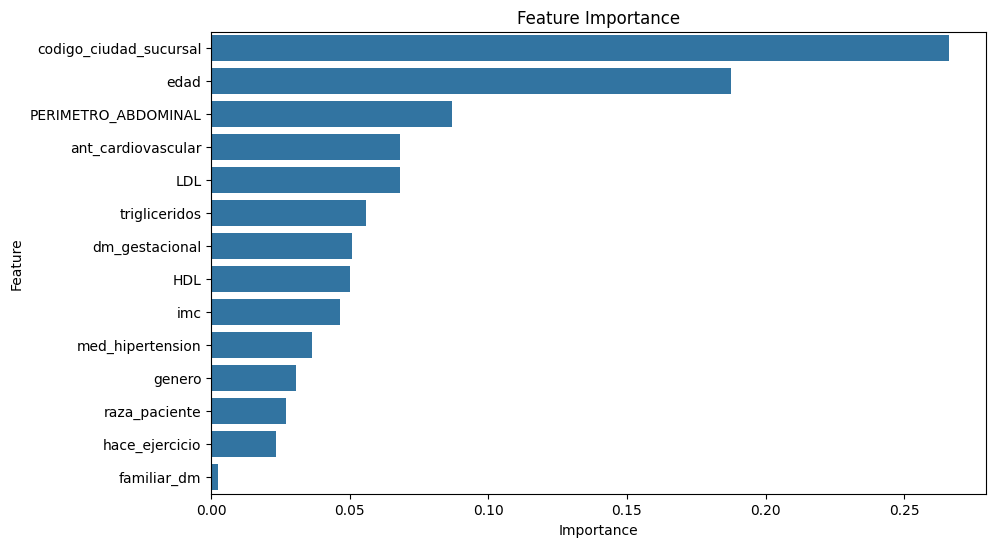

In [116]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [117]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 71.71
Modelo entrenado con f1 de: 32.57
La matriz de confusion es:


,Negativo,Positivo
Negativo,62633,4800
Positivo,22508,6596


In [118]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 3.28%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
66696,0.0,33.0,0.0,70001.0,4.0,0.0,55.0,1.62,20.957171,48.2,61.0,64.0,0.0,0.0,0.0,0.0,72.0,0.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 11.45%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
69346,0.0,62.0,0.0,52356.0,0.0,1.0,47.0,1.37,25.041291,38.0,234.0,142.0,0.0,0.0,0.0,0.0,76.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 20.91%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
20672,0.0,50.0,0.0,68001.0,5.0,0.0,61.3,1.55,25.515088,46.0,102.0,91.0,0.0,0.0,0.0,0.0,85.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 70.38%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
123091,0.0,69.0,1.0,41001.0,0.0,0.0,91.0,1.76,29.377583,27.5,35.0,236.4,0.0,0.0,1.0,0.0,110.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 25.8%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
228986,0.0,63.0,1.0,68081.0,3.0,0.0,78.0,1.7,26.989619,56.8,89.4,59.0,1.0,0.0,1.0,0.0,100.0,3.0,0.0


## Evaluación sin las variables 
raza_paciente

In [119]:
# Conjunto de variables a usar en el entrenamiento
# Sin raza_paciente

variables_to_train_sin_13 = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal', # Mirar
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente', # Mirar
                      'diabetes']

In [120]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_13].copy()
df_to_train.head(5)

,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,diabetes
0,2,0.0,11001.0,0,1,0,0,0,0,0,0,0,2,0.0,0.0
1,2,0.0,54001.0,0,1,0,2,0,0,0,0,0,2,1.0,0.0
2,3,0.0,15001.0,0,0,2,0,0,0,0,0,0,0,2.0,0.0
3,2,0.0,8001.0,0,2,1,2,0,0,0,0,2,2,3.0,1.0
4,1,0.0,19001.0,0,1,1,1,0,0,0,0,0,2,4.0,0.0


In [121]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_13[:-1]]
y = df_to_train[variables_to_train_sin_13[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente
0,2,0.0,11001.0,0,1,0,0,0,0,0,0,0,2,0.0
1,2,0.0,54001.0,0,1,0,2,0,0,0,0,0,2,1.0
2,3,0.0,15001.0,0,0,2,0,0,0,0,0,0,0,2.0
3,2,0.0,8001.0,0,2,1,2,0,0,0,0,2,2,3.0
4,1,0.0,19001.0,0,1,1,1,0,0,0,0,0,2,4.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

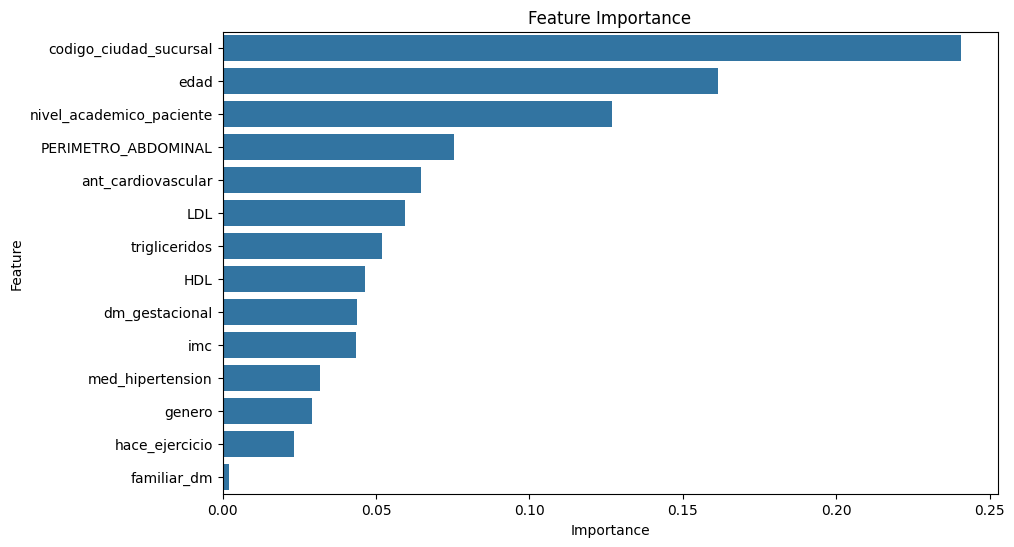

In [122]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [123]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 71.85
Modelo entrenado con f1 de: 32.48
La matriz de confusion es:


,Negativo,Positivo
Negativo,62823,4610
Positivo,22568,6536


In [124]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 7.03%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
19918,0.0,20.0,0.0,19001.0,4.0,0.0,109.0,1.7,37.716263,42.5,104.0,162.0,0.0,0.0,0.0,0.0,90.0,1.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 34.82%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
258196,0.0,52.0,1.0,68276.0,4.0,0.0,107.0,1.75,34.938776,42.0,128.0,110.0,1.0,0.0,1.0,0.0,131.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 54.52%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
111181,0.0,56.0,1.0,8001.0,4.0,0.0,84.0,1.8,25.925926,43.0,37.0,87.0,0.0,0.0,1.0,0.0,94.0,0.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 17.59%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
46417,0.0,63.0,0.0,25175.0,7.0,0.0,52.0,1.52,22.506925,44.3,120.46,104.16,1.0,0.0,0.0,0.0,79.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 25.92%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
215018,0.0,46.0,1.0,73349.0,7.0,4.0,113.0,1.78,35.664689,51.0,105.1,196.0,1.0,0.0,1.0,0.0,114.0,1.0,0.0


## Evaluación sin las variables 
nivel_academico_paciente y raza_paciente

In [9]:
# Conjunto de variables a usar en el entrenamiento
# Sin nivel_academico_paciente
# Sin raza_paciente

variables_to_train_sin_14 = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal', # Mirar
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'diabetes']

In [10]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_14].copy()
df_to_train.head(5)

,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
0,2,0.0,11001.0,0,1,0,0,0,0,0,0,0,2,0.0
1,2,0.0,54001.0,0,1,0,2,0,0,0,0,0,2,0.0
2,3,0.0,15001.0,0,0,2,0,0,0,0,0,0,0,0.0
3,2,0.0,8001.0,0,2,1,2,0,0,0,0,2,2,1.0
4,1,0.0,19001.0,0,1,1,1,0,0,0,0,0,2,0.0


In [11]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_14 [:-1]]
y = df_to_train[variables_to_train_sin_14 [-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio
0,2,0.0,11001.0,0,1,0,0,0,0,0,0,0,2
1,2,0.0,54001.0,0,1,0,2,0,0,0,0,0,2
2,3,0.0,15001.0,0,0,2,0,0,0,0,0,0,0
3,2,0.0,8001.0,0,2,1,2,0,0,0,0,2,2
4,1,0.0,19001.0,0,1,1,1,0,0,0,0,0,2


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

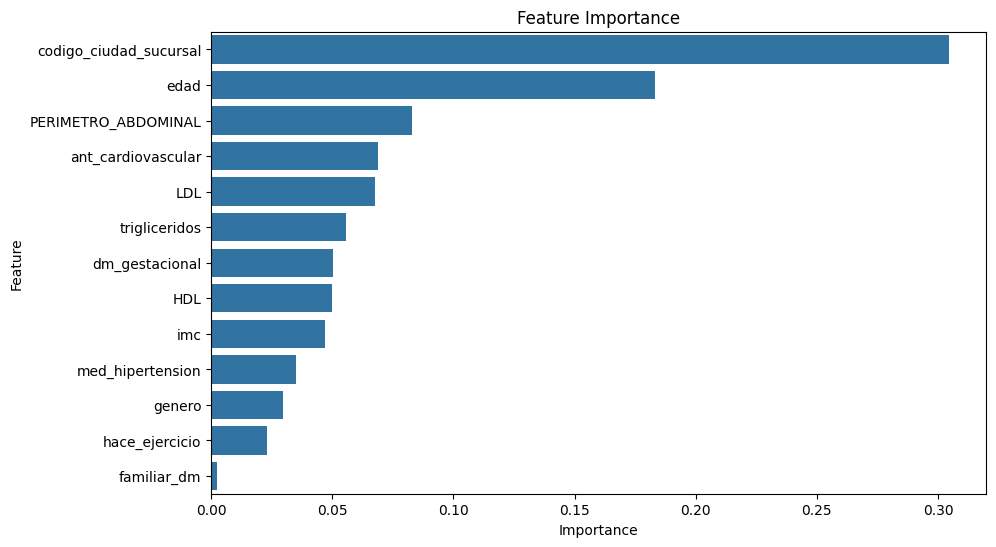

In [12]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [13]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 71.52
Modelo entrenado con f1 de: 33.15
La matriz de confusion es:


,Negativo,Positivo
Negativo,62225,5208
Positivo,22288,6816


In [14]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 39.49%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
291299,0.0,53.0,0.0,20011.0,3.0,0.0,73.0,1.62,27.815882,31.0,111.2,249.0,1.0,0.0,1.0,0.0,91.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 48.71%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
243028,0.0,66.0,1.0,13001.0,4.0,0.0,90.0,1.81,27.471689,59.0,47.84,61.8,1.0,0.0,1.0,0.0,103.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 26.55%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
286516,0.0,59.0,0.0,11001.0,0.0,0.0,89.9,1.57,36.472068,61.0,78.0,106.0,1.0,0.0,1.0,0.0,104.0,0.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 46.5%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
234618,0.0,66.0,1.0,23466.0,4.0,0.0,78.8,1.71,26.948463,43.1,71.0,69.1,1.0,0.0,1.0,0.0,96.0,1.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 24.22%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
250120,0.0,73.0,0.0,76001.0,4.0,0.0,56.0,1.52,24.238227,76.0,143.0,79.0,1.0,0.0,1.0,0.0,77.0,1.0,0.0


Cluster = False
Sample = False

## Todas las variables

In [29]:
# Conjunto de variables a usar en el entrenamiento

variables_to_train_sin_15 = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal', # Mirar
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente', # Mirar
                      'raza_paciente', # Mirar
                      'diabetes']

In [30]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_15].copy()
df_to_train.head(5)

,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente,diabetes
0,64.0,0.0,11001.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0,0.0,0.0
1,54.0,0.0,54001.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,1.0,0.0,0.0
2,69.0,0.0,15001.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,2.0,0.0,0.0
3,57.0,0.0,8001.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,3.0,0.0,1.0
4,50.0,0.0,19001.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,4.0,0.0,0.0


In [31]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_15[:-1]]
y = df_to_train[variables_to_train_sin_15[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
0,64.0,0.0,11001.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0,0.0
1,54.0,0.0,54001.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,1.0,0.0
2,69.0,0.0,15001.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,2.0,0.0
3,57.0,0.0,8001.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,3.0,0.0
4,50.0,0.0,19001.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,4.0,0.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

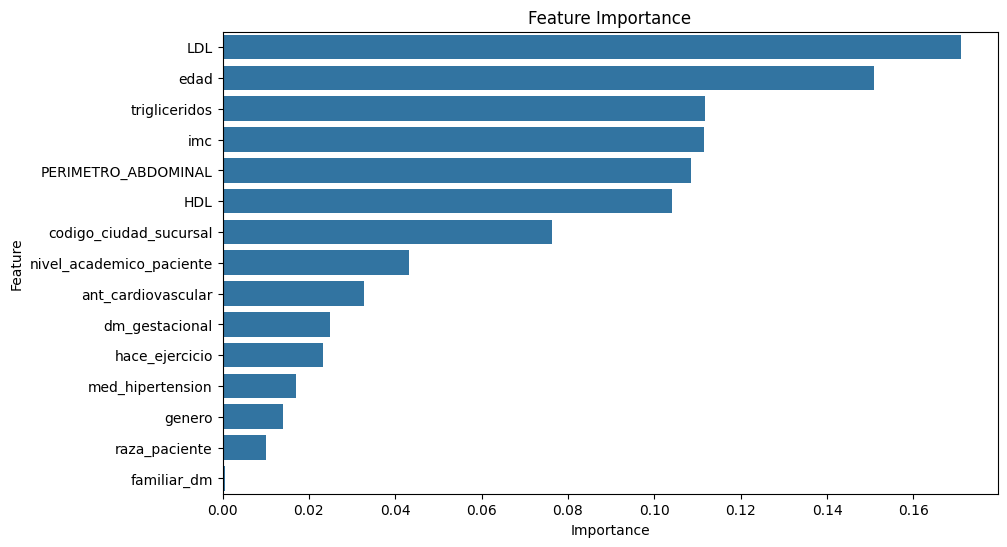

In [32]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [33]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 74.91
Modelo entrenado con f1 de: 42.09
La matriz de confusion es:


,Negativo,Positivo
Negativo,63517,3993
Positivo,20225,8802


In [34]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 15.29%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
133293,0.0,56.0,0.0,5001.0,5.0,0.0,69.0,1.68,24.447279,55.92,165.24,148.7,0.0,0.0,1.0,0.0,85.0,0.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 20.93%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
92016,0.0,51.0,0.0,15001.0,0.0,0.0,69.3,1.48,31.638057,42.0,101.0,130.0,1.0,0.0,1.0,0.0,99.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 28.49%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
59266,0.0,40.0,0.0,19001.0,0.0,0.0,88.0,1.6,34.375,33.1,33.4,113.5,0.0,0.0,0.0,0.0,92.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 2.62%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
11284,0.0,34.0,0.0,11001.0,0.0,0.0,61.0,1.617,23.329734,47.0,73.0,53.0,0.0,0.0,0.0,0.0,69.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 21.24%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
230647,0.0,47.0,1.0,8001.0,0.0,1.0,91.0,1.74,30.056811,55.0,170.0,249.0,1.0,0.0,1.0,0.0,102.0,3.0,1.0


## Evaluación sin las variables
codigo_ciudad_sucursal, nivel_academico_paciente y raza_paciente 

In [35]:
# Conjunto de variables a usar en el entrenamiento
# Sin codigo_ciudad_sucursal
# Sin nivel_academico_paciente
# Sin raza_paciente 

variables_to_train_sin_16 = ['edad',
                      'genero',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'diabetes']



In [36]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_16].copy()
df_to_train.head(5)

,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
0,64.0,0.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0
1,54.0,0.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,0.0
2,69.0,0.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,0.0
3,57.0,0.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,1.0
4,50.0,0.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,0.0


In [37]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_16[:-1]]
y = df_to_train[variables_to_train_sin_16[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio
0,64.0,0.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0
1,54.0,0.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0
2,69.0,0.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0
3,57.0,0.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0
4,50.0,0.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

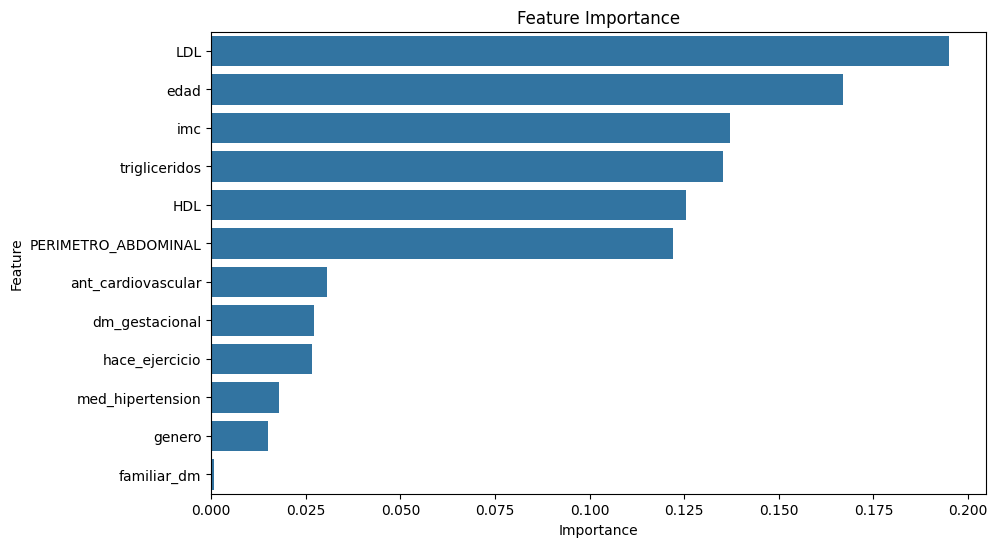

In [38]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [39]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 74.5
Modelo entrenado con f1 de: 41.5
La matriz de confusion es:


,Negativo,Positivo
Negativo,63188,4322
Positivo,20296,8731


In [40]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 24.14%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
102320,0.0,78.0,0.0,41001.0,3.0,0.0,59.5,1.5,26.444444,54.3,174.8,154.7,1.0,0.0,1.0,0.0,90.0,1.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 36.02%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
163904,0.0,65.0,1.0,11001.0,1.0,0.0,80.0,1.752,26.062843,44.7,86.82,110.01,1.0,0.0,1.0,0.0,95.0,2.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 13.18%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
41891,0.0,55.0,1.0,15001.0,3.0,0.0,72.0,1.62,27.434842,43.0,151.0,152.0,0.0,0.0,0.0,0.0,89.0,2.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 36.22%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
118205,0.0,74.0,0.0,54001.0,0.0,0.0,70.0,1.54,29.515939,35.9,117.7,147.0,1.0,0.0,1.0,0.0,99.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 40.17%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
264445,0.0,75.0,0.0,15001.0,0.0,0.0,62.3,1.6,24.335938,48.0,115.0,149.0,0.0,0.0,1.0,0.0,89.0,2.0,1.0


## Evaluación sin las variables
codigo_ciudad_sucursal y nivel_academico_paciente 

In [41]:
# Conjunto de variables a usar en el entrenamiento
# Sin codigo_ciudad_sucursal
# Sin nivel_academico_paciente

variables_to_train_sin_17 = ['edad',
                      'genero',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'raza_paciente', # Mirar
                      'diabetes']

In [42]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_17].copy()
df_to_train.head(5)

,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,raza_paciente,diabetes
0,64.0,0.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0,0.0
1,54.0,0.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,0.0,0.0
2,69.0,0.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,0.0,0.0
3,57.0,0.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,0.0,1.0
4,50.0,0.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,0.0,0.0


In [43]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_17[:-1]]
y = df_to_train[variables_to_train_sin_17[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,raza_paciente
0,64.0,0.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0
1,54.0,0.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,0.0
2,69.0,0.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,0.0
3,57.0,0.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,0.0
4,50.0,0.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,0.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

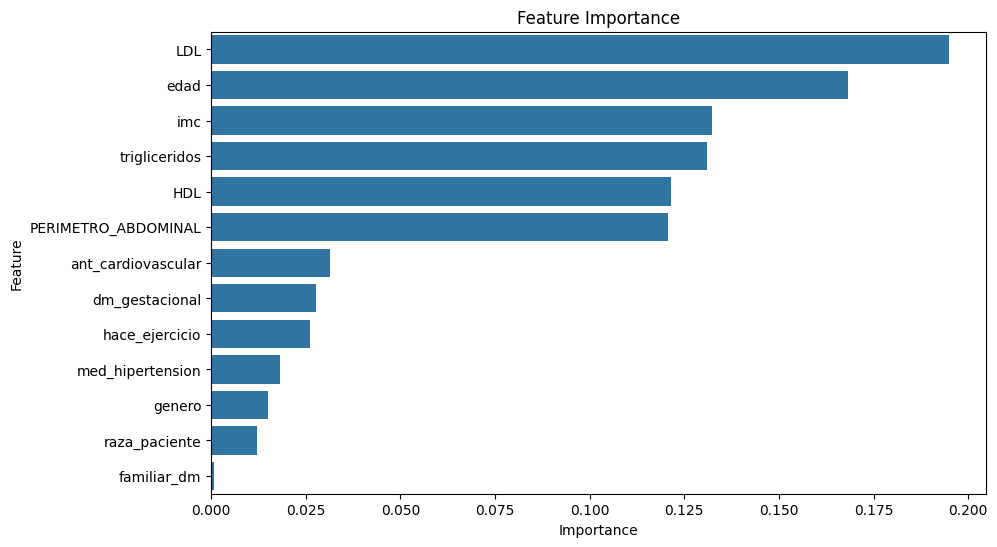

In [44]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [45]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 74.38
Modelo entrenado con f1 de: 41.08
La matriz de confusion es:


,Negativo,Positivo
Negativo,63183,4327
Positivo,20406,8621


In [46]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 27.35%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
168632,0.0,81.0,0.0,11001.0,7.0,0.0,50.0,1.54,21.082813,75.0,65.0,75.0,1.0,0.0,1.0,0.0,84.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 51.33%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
131223,0.0,55.0,0.0,11001.0,0.0,0.0,75.0,1.55,31.217482,50.0,92.0,298.0,1.0,0.0,1.0,0.0,104.0,2.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 28.69%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
218527,0.0,60.0,1.0,11001.0,0.0,0.0,77.4,1.67,27.752877,63.0,109.0,113.0,1.0,0.0,1.0,0.0,95.0,1.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 40.3%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
152916,0.0,71.0,0.0,19001.0,0.0,0.0,87.0,1.56,35.749507,48.0,109.0,100.0,1.0,0.0,1.0,0.0,109.0,2.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 22.23%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
207935,0.0,47.0,0.0,68001.0,4.0,0.0,106.8,1.65,39.22865,59.8,137.07,110.0,1.0,0.0,1.0,0.0,116.0,3.0,0.0


## Evaluación sin las variables
codigo_ciudad_sucursal y raza_paciente

In [47]:
# Conjunto de variables a usar en el entrenamiento
# Sin codigo_ciudad_sucursal
# Sin raza_paciente

variables_to_train_sin_18 = ['edad',
                      'genero',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente', # Mirar
                      'diabetes']

In [48]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_18].copy()
df_to_train.head(5)

,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,diabetes
0,64.0,0.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0,0.0
1,54.0,0.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,1.0,0.0
2,69.0,0.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,2.0,0.0
3,57.0,0.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,3.0,1.0
4,50.0,0.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,4.0,0.0


In [49]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_18[:-1]]
y = df_to_train[variables_to_train_sin_18[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente
0,64.0,0.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0
1,54.0,0.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,1.0
2,69.0,0.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,2.0
3,57.0,0.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,3.0
4,50.0,0.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,4.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

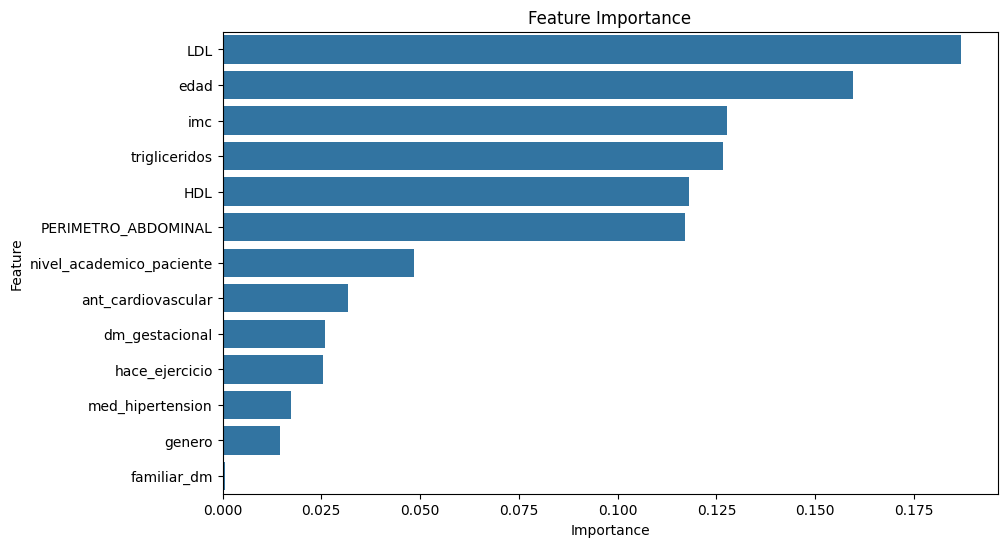

In [50]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [51]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 74.58
Modelo entrenado con f1 de: 41.53
La matriz de confusion es:


,Negativo,Positivo
Negativo,63281,4229
Positivo,20312,8715


In [52]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 19.72%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
55846,0.0,59.0,0.0,19001.0,4.0,0.0,72.0,1.64,26.76978,35.8,108.0,375.0,0.0,0.0,0.0,0.0,88.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 51.95%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
290487,0.0,70.0,1.0,54001.0,0.0,0.0,72.3,1.72,24.438886,32.1,66.5,168.0,1.0,0.0,1.0,0.0,87.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 18.76%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
20944,0.0,33.0,0.0,11001.0,3.0,0.0,88.0,1.65,32.323232,53.0,67.0,181.0,1.0,0.0,0.0,0.0,100.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 52.84%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
91285,0.0,80.0,1.0,52001.0,1.0,1.0,82.0,1.58,32.8473,52.0,41.6,77.0,1.0,0.0,1.0,0.0,112.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 5.87%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
72971,0.0,36.0,0.0,11001.0,4.0,0.0,60.5,1.63,22.770898,30.0,79.0,85.0,0.0,0.0,0.0,0.0,80.0,3.0,0.0


## Evaluación sin las variables 
nivel_academico_paciente y raza_paciente

In [53]:
# Conjunto de variables a usar en el entrenamiento
# Sin nivel_academico_paciente
# Sin raza_paciente

variables_to_train_sin_19 = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal', # Mirar
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'diabetes']


In [54]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_19].copy()
df_to_train.head(5)

,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
0,64.0,0.0,11001.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0
1,54.0,0.0,54001.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,0.0
2,69.0,0.0,15001.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,0.0
3,57.0,0.0,8001.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,1.0
4,50.0,0.0,19001.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,0.0


In [55]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_19[:-1]]
y = df_to_train[variables_to_train_sin_19[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio
0,64.0,0.0,11001.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0
1,54.0,0.0,54001.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0
2,69.0,0.0,15001.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0
3,57.0,0.0,8001.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0
4,50.0,0.0,19001.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

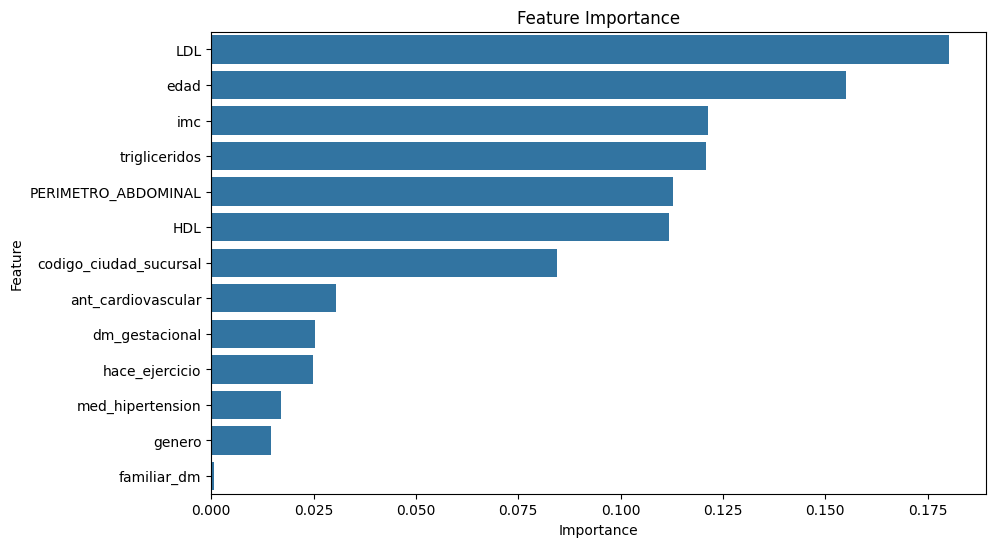

In [56]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [57]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 75.06
Modelo entrenado con f1 de: 43.13
La matriz de confusion es:


,Negativo,Positivo
Negativo,63327,4183
Positivo,19897,9130


In [58]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 36.67%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
135616,0.0,59.0,1.0,5001.0,1.0,0.0,95.0,1.65,34.894399,44.0,118.0,136.0,1.0,0.0,1.0,0.0,121.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 32.37%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
220433,0.0,67.0,0.0,70001.0,0.0,0.0,64.0,1.58,25.636917,53.19,72.1,132.1,1.0,0.0,1.0,0.0,86.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 11.48%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
107414,0.0,54.0,0.0,52001.0,7.0,1.0,46.8,1.43,22.886205,52.0,112.0,180.0,1.0,0.0,1.0,0.0,73.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 35.82%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
35745,0.0,57.0,0.0,25307.0,3.0,0.0,80.0,1.69,28.010224,47.64,80.21,145.44,0.0,0.0,0.0,0.0,92.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 44.3%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
190315,0.0,74.0,1.0,15001.0,0.0,0.0,76.0,1.57,30.832894,36.0,190.0,253.0,1.0,0.0,1.0,0.0,109.0,2.0,0.0


## Evaluación sin las variables
codigo_ciudad_sucursal

In [59]:
# Conjunto de variables a usar en el entrenamiento
# Sin codigo_ciudad_sucursal

variables_to_train_sin_20 = ['edad',
                      'genero',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente', # Mirar
                      'raza_paciente', # Mirar
                      'diabetes']

In [60]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_20].copy()
df_to_train.head(5)

,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente,diabetes
0,64.0,0.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0,0.0,0.0
1,54.0,0.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,1.0,0.0,0.0
2,69.0,0.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,2.0,0.0,0.0
3,57.0,0.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,3.0,0.0,1.0
4,50.0,0.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,4.0,0.0,0.0


In [61]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_20[:-1]]
y = df_to_train[variables_to_train_sin_20[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
0,64.0,0.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0,0.0
1,54.0,0.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,1.0,0.0
2,69.0,0.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,2.0,0.0
3,57.0,0.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,3.0,0.0
4,50.0,0.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,4.0,0.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

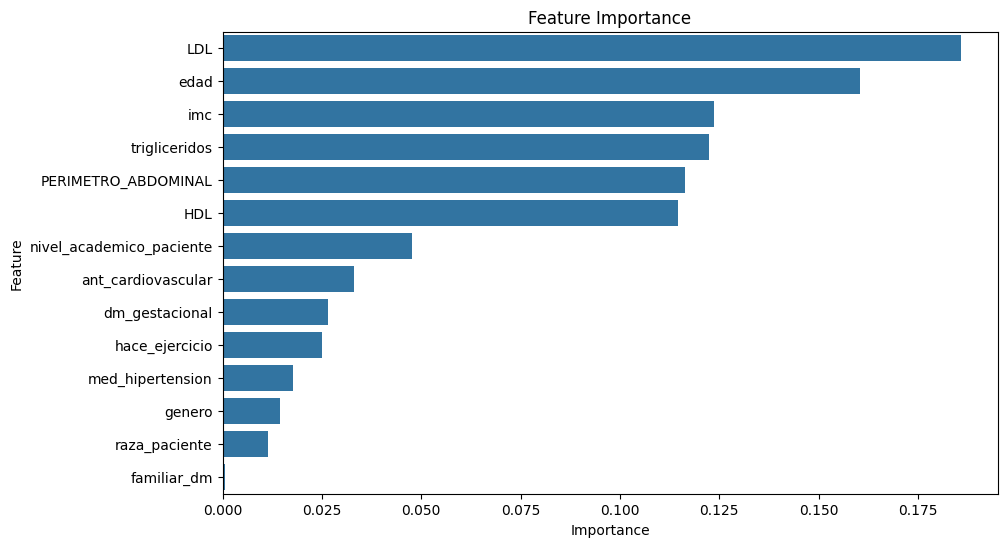

In [62]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [63]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 74.55
Modelo entrenado con f1 de: 41.25
La matriz de confusion es:


,Negativo,Positivo
Negativo,63341,4169
Positivo,20400,8627


In [64]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 22.22%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
220704,0.0,76.0,1.0,8001.0,2.0,0.0,71.6,1.7,24.775087,56.9,105.7,86.0,1.0,0.0,1.0,0.0,70.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 28.57%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
30939,0.0,69.0,1.0,11001.0,3.0,0.0,69.5,1.66,25.221367,51.1,143.0,113.88,0.0,0.0,0.0,0.0,97.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 42.82%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
178547,0.0,53.0,1.0,8758.0,7.0,0.0,107.0,1.71,36.592456,36.8,118.4,225.0,0.0,0.0,1.0,0.0,120.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 50.11%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
253742,0.0,72.0,1.0,11001.0,3.0,0.0,66.0,1.6,25.78125,35.5,89.69,300.27,0.0,0.0,1.0,0.0,95.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 50.69%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
160298,0.0,68.0,0.0,8001.0,0.0,0.0,89.0,1.55,37.044745,45.0,120.0,166.0,1.0,0.0,1.0,0.0,119.0,3.0,0.0


## Evaluación sin las variables
nivel_academico_paciente 

In [65]:
# Conjunto de variables a usar en el entrenamiento
# Sin nivel_academico_paciente

variables_to_train_sin_21 = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal', # Mirar
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'raza_paciente', # Mirar
                      'diabetes']

In [66]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_21].copy()
df_to_train.head(5)

,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,raza_paciente,diabetes
0,64.0,0.0,11001.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0,0.0
1,54.0,0.0,54001.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,0.0,0.0
2,69.0,0.0,15001.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,0.0,0.0
3,57.0,0.0,8001.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,0.0,1.0
4,50.0,0.0,19001.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,0.0,0.0


In [67]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_21[:-1]]
y = df_to_train[variables_to_train_sin_21[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,raza_paciente
0,64.0,0.0,11001.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0
1,54.0,0.0,54001.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,0.0
2,69.0,0.0,15001.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,0.0
3,57.0,0.0,8001.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,0.0
4,50.0,0.0,19001.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,0.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

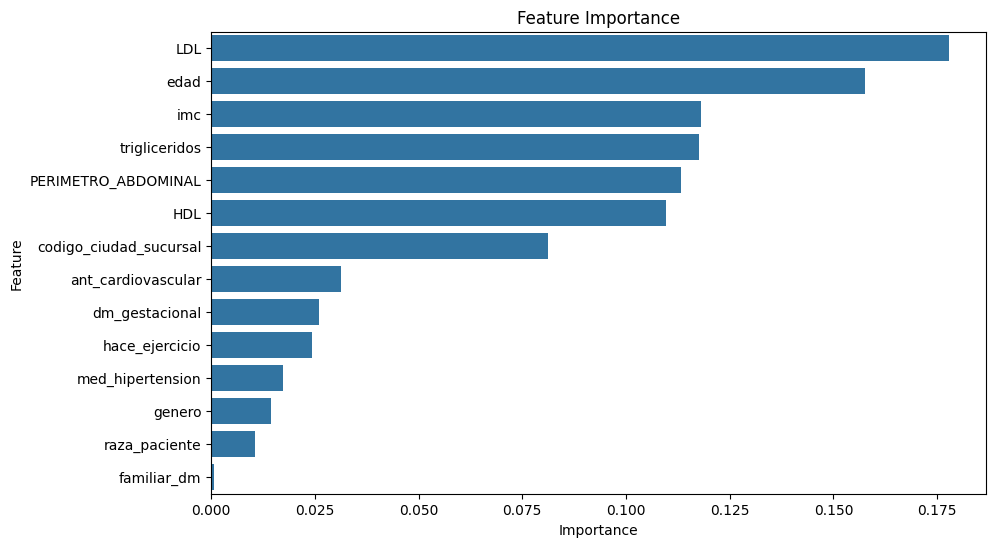

In [68]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [69]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 74.83
Modelo entrenado con f1 de: 42.18
La matriz de confusion es:


,Negativo,Positivo
Negativo,63381,4129
Positivo,20166,8861


In [70]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 61.9%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
220699,0.0,87.0,0.0,47001.0,5.0,0.0,85.6,1.46,40.157628,36.0,59.0,240.0,1.0,0.0,1.0,0.0,115.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 68.62%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
94617,0.0,72.0,0.0,5001.0,0.0,0.0,72.0,1.51,31.577562,51.8,51.3,125.9,0.0,0.0,1.0,0.0,94.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 40.76%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
110323,0.0,60.0,1.0,8001.0,0.0,0.0,76.0,1.74,25.102391,59.0,52.0,84.0,1.0,0.0,1.0,0.0,90.0,0.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 25.84%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
53038,0.0,59.0,1.0,73001.0,3.0,0.0,83.4,1.66,30.265641,40.9,148.2,125.9,0.0,0.0,0.0,0.0,99.0,0.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 30.53%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
238638,0.0,73.0,0.0,41001.0,9.0,0.0,83.0,1.57,33.672766,57.3,134.0,98.7,1.0,0.0,1.0,0.0,98.0,3.0,0.0


## Evaluación sin las variables 
raza_paciente

In [71]:
# Conjunto de variables a usar en el entrenamiento
# Sin raza_paciente

variables_to_train_sin_22 = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal', # Mirar
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente', # Mirar
                      'diabetes']

In [72]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train_sin_22].copy()
df_to_train.head(5)

,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,diabetes
0,64.0,0.0,11001.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0,0.0
1,54.0,0.0,54001.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,1.0,0.0
2,69.0,0.0,15001.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,2.0,0.0
3,57.0,0.0,8001.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,3.0,1.0
4,50.0,0.0,19001.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,4.0,0.0


In [73]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train_sin_22[:-1]]
y = df_to_train[variables_to_train_sin_22[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente
0,64.0,0.0,11001.0,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0
1,54.0,0.0,54001.0,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,1.0
2,69.0,0.0,15001.0,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,2.0
3,57.0,0.0,8001.0,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,3.0
4,50.0,0.0,19001.0,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,4.0


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

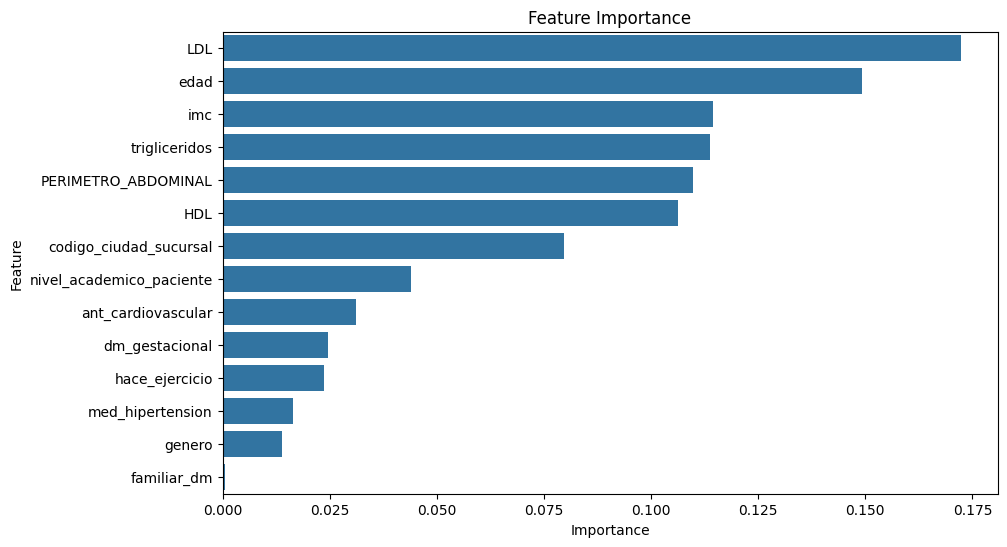

In [74]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [75]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 75.13
Modelo entrenado con f1 de: 42.83
La matriz de confusion es:


,Negativo,Positivo
Negativo,63530,3980
Positivo,20033,8994


In [76]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 5.92%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
238460,0.0,37.0,1.0,50001.0,0.0,0.0,83.0,1.74,27.414454,40.6,115.12,168.9,1.0,0.0,1.0,0.0,95.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 13.07%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
97456,0.0,59.0,0.0,8001.0,7.0,0.0,62.0,1.52,26.83518,66.1,165.3,116.0,1.0,0.0,1.0,0.0,86.0,0.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 27.0%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
31416,0.0,64.0,0.0,54001.0,1.0,0.0,54.2,1.53,23.153488,71.0,119.0,137.0,0.0,0.0,0.0,0.0,85.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 50.1%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
124366,0.0,63.0,0.0,41001.0,1.0,0.0,65.2,1.53,27.852535,36.0,98.0,654.0,1.0,0.0,1.0,0.0,93.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 34.69%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
122973,0.0,54.0,0.0,11001.0,3.0,0.0,69.1,1.58,27.679859,43.3,204.8,291.99,1.0,0.0,1.0,0.0,99.0,3.0,1.0
